In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [21]:
# Read the data
df = pd.read_csv('data.csv')

In [22]:
# Convert monthly columns to numeric if they aren't already
months = ['September', 'August', 'July', 'June', 'May', 'April', 'March']
for month in months:
    # Check if conversion is needed
    if df[month].dtype == 'object':
        df[month] = pd.to_numeric(df[month].astype(str).str.replace(',', ''), errors='coerce')
    else:
        df[month] = pd.to_numeric(df[month], errors='coerce')

In [23]:
# Create average monthly consumption
df['avg_consumption'] = df[months].mean(axis=1)

# Extract latitude and longitude
df[['Latitude', 'Longitude']] = df['Latitude,Longitue'].str.extract(r'([\d.]+),\s*([\d.]+)')
df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].astype(float)

print("Data Overview:")
print(df.describe())

Data Overview:
        #Person  Carpet-Area   September      August       July        June  \
count  14.00000    14.000000   14.000000   14.000000   14.00000   14.000000   
mean    3.50000   992.857143  102.500000   98.857143  100.00000   88.571429   
std     1.60528   336.187415   85.250536   81.378373   81.40686   74.480472   
min     1.00000   500.000000   13.000000   12.000000   11.00000   12.000000   
25%     3.00000   725.000000   45.500000   38.500000   47.00000   40.000000   
50%     3.00000  1000.000000   72.500000   74.000000   72.50000   73.000000   
75%     4.00000  1175.000000  143.000000  138.750000  144.25000  102.750000   
max     8.00000  1600.000000  300.000000  285.000000  290.00000  273.000000   

              May       April       March  avg_consumption   Latitude  \
count   14.000000   14.000000   14.000000        14.000000  14.000000   
mean    87.428571   85.500000   84.214286        92.438776  23.187579   
std     75.569341   73.127654   73.310906        76.09

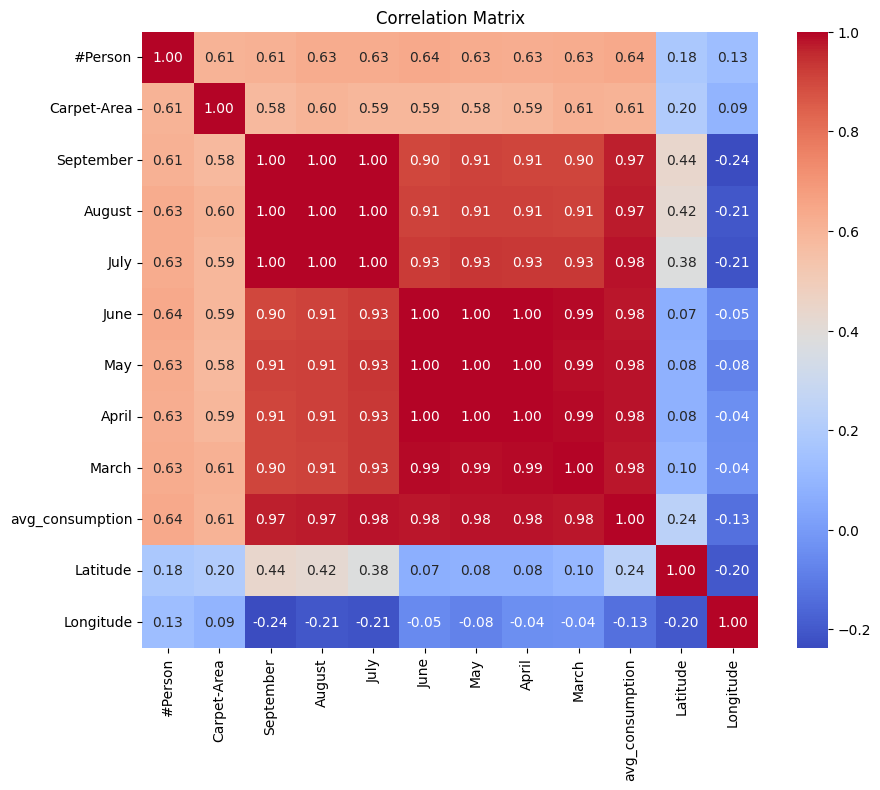

In [24]:
# Dropping non-numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [25]:
monthly_cols = ['September', 'August', 'July', 'June', 'May', 'April', 'March']
df['avg_consumption'] = df[monthly_cols].mean(axis=1)

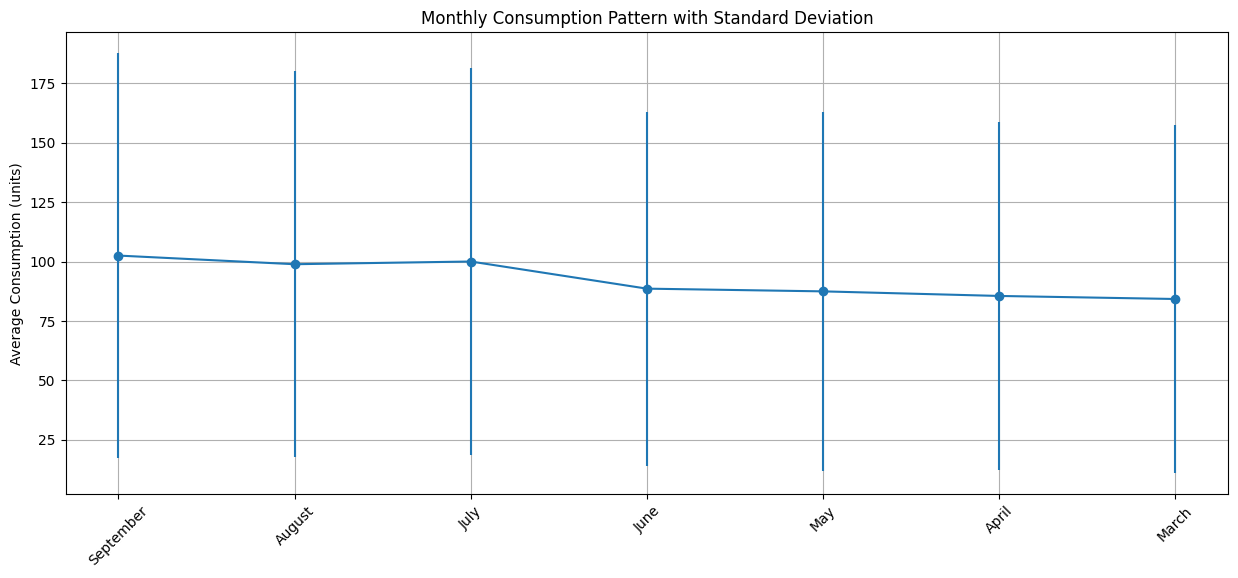


Month-to-month average consumption changes:
August to September: 3.64 units (3.7%)
July to August: -1.14 units (-1.1%)
June to July: 11.43 units (12.9%)
May to June: 1.14 units (1.3%)
April to May: 1.93 units (2.3%)
March to April: 1.29 units (1.5%)


C:\Users\shory\AppData\Local\Temp\ipykernel_24596\3987516376.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  change = monthly_avg[i] - monthly_avg[i+1]
C:\Users\shory\AppData\Local\Temp\ipykernel_24596\3987516376.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percent_change = (change / monthly_avg[i+1]) * 100


In [26]:
# Monthly consumption patterns
plt.figure(figsize=(15, 6))
monthly_avg = df[months].mean()
monthly_std = df[months].std()

plt.errorbar(range(len(months)), monthly_avg, yerr=monthly_std, fmt='o-')
plt.xticks(range(len(months)), months, rotation=45)
plt.title('Monthly Consumption Pattern with Standard Deviation')
plt.ylabel('Average Consumption (units)')
plt.grid(True)
plt.show()

# Calculate month-to-month changes
print("\nMonth-to-month average consumption changes:")
for i in range(len(months)-1):
    change = monthly_avg[i] - monthly_avg[i+1]
    percent_change = (change / monthly_avg[i+1]) * 100
    print(f"{months[i+1]} to {months[i]}: {change:.2f} units ({percent_change:.1f}%)")


Correlation between Carpet Area and consumption: 0.606


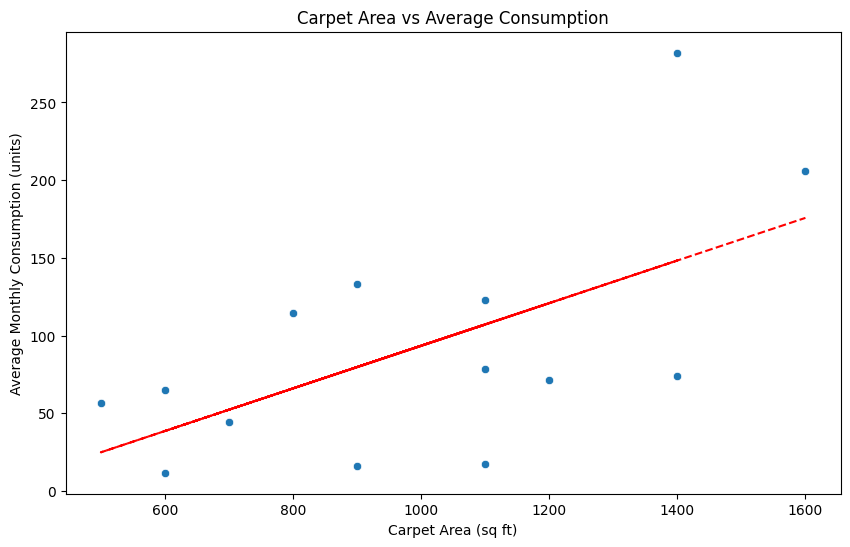

Linear equation: Consumption = 0.14 × Carpet-Area + -43.73


In [27]:
# Relationship between consumption and Carpet Area (BUA)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Carpet-Area', y='avg_consumption')
plt.title('Carpet Area vs Average Consumption')
plt.xlabel('Carpet Area (sq ft)')
plt.ylabel('Average Monthly Consumption (units)')

# Calculate correlation
correlation_bua = stats.pearsonr(df['Carpet-Area'], df['avg_consumption'])[0]
print(f"\nCorrelation between Carpet Area and consumption: {correlation_bua:.3f}")

# Fit a simple linear regression
X_bua = df['Carpet-Area'].values.reshape(-1, 1)
y_bua = df['avg_consumption'].values
reg_bua = LinearRegression().fit(X_bua, y_bua)
plt.plot(X_bua, reg_bua.predict(X_bua), color='red', linestyle='--')
plt.show()

# Print regression equation
print(f"Linear equation: Consumption = {reg_bua.coef_[0]:.2f} × Carpet-Area + {reg_bua.intercept_:.2f}")

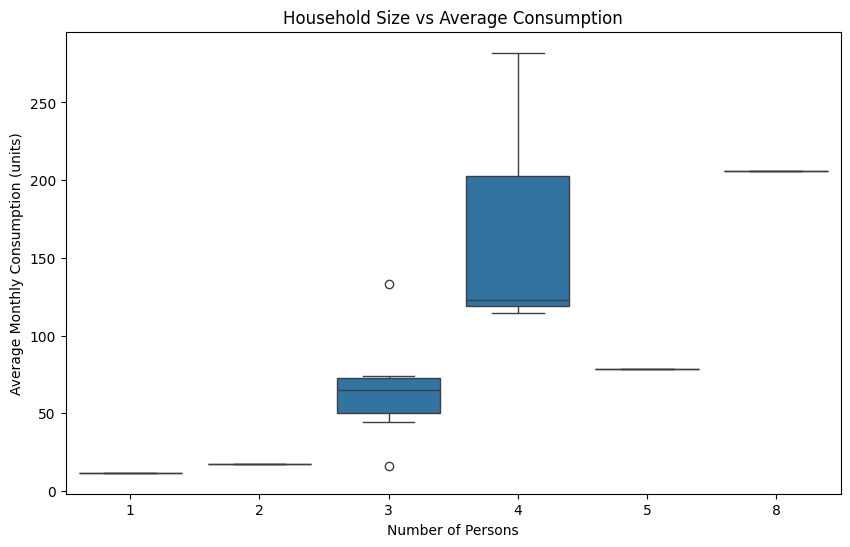


Consumption by household size:
               mean        std  count
#Person                              
1         11.714286        NaN      1
2         17.142857        NaN      1
3         65.857143  35.800942      7
4        173.190476  94.332492      3
5         78.714286        NaN      1
8        206.000000        NaN      1

Correlation between household size and consumption: 0.642


In [28]:
# Relationship between consumption and household size
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='#Person', y='avg_consumption')
plt.title('Household Size vs Average Consumption')
plt.xlabel('Number of Persons')
plt.ylabel('Average Monthly Consumption (units)')
plt.show()

# Calculate average consumption per household size
household_consumption = df.groupby('#Person')['avg_consumption'].agg(['mean', 'std', 'count'])
print("\nConsumption by household size:")
print(household_consumption)

# Calculate correlation
correlation_size = stats.pearsonr(df['#Person'], df['avg_consumption'])[0]
print(f"\nCorrelation between household size and consumption: {correlation_size:.3f}")

In [29]:
# Create derived features
df['appliance_count'] = df['Types-of-appliances'].str.count(',') + 1
df['has_ac'] = df['Types-of-appliances'].str.contains('Air conditioner').astype(int)
df['has_heater'] = df['Types-of-appliances'].str.contains('Water Heater').astype(int)
df['area_per_person'] = df['Carpet-Area'] / df['#Person']

# Prepare enhanced feature set
X_enhanced = df[[
    'Carpet-Area', '#Person', 'appliance_count', 'has_ac', 
    'has_heater', 'area_per_person'
]]
y = df['avg_consumption']

# Split and train
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42
)

# Fit enhanced model
model_enhanced = LinearRegression()
model_enhanced.fit(X_train_enh, y_train_enh)

# Evaluate
y_pred_enh = model_enhanced.predict(X_test_enh)
r2_enh = r2_score(y_test_enh, y_pred_enh)
rmse_enh = np.sqrt(mean_squared_error(y_test_enh, y_pred_enh))

print("\nEnhanced Model Results:")
print(f"R-squared score: {r2_enh:.3f}")
print(f"RMSE: {rmse_enh:.3f}")
print("\nFeature importance:")
for feature, coef in zip(X_enhanced.columns, model_enhanced.coef_):
    print(f"{feature}: {coef:.3f}")


Enhanced Model Results:
R-squared score: -47.905
RMSE: 86.900

Feature importance:
Carpet-Area: 0.136
#Person: -26.416
appliance_count: 54.105
has_ac: -158.850
has_heater: -15.213
area_per_person: -0.386


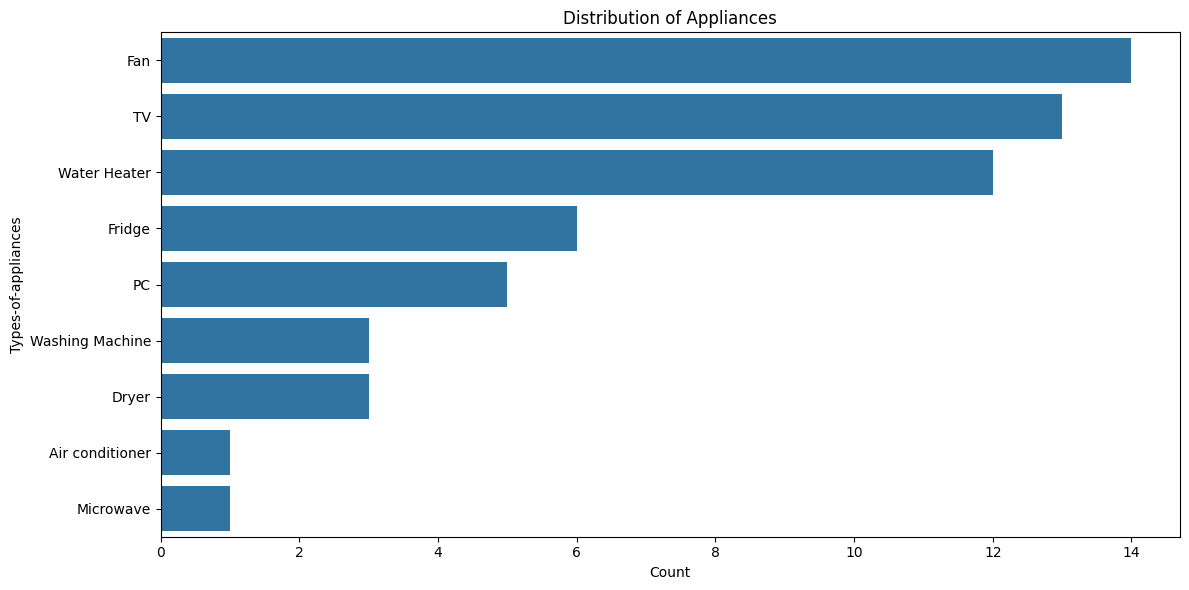

In [30]:
# Appliance analysis
plt.figure(figsize=(12, 6))
appliance_counts = df['Types-of-appliances'].str.split(',').explode().str.strip().value_counts()
sns.barplot(x=appliance_counts.values, y=appliance_counts.index)
plt.title('Distribution of Appliances')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

In [31]:
# Consumption metrics
print("\nKey Consumption Metrics:")
print(f"Average consumption per person: {(df['avg_consumption'] / df['#Person']).mean():.2f} units")
print(f"Average area per person: {df['area_per_person'].mean():.2f} sq ft")
print(f"Most common household size: {df['#Person'].mode().values[0]} persons")
print(f"Percentage of homes with AC: {(df['has_ac'].mean() * 100):.1f}%")
print(f"Average consumption by AC homes: {df[df['has_ac'] == 1]['avg_consumption'].mean():.2f} units")
print(f"Average consumption by non-AC homes: {df[df['has_ac'] == 0]['avg_consumption'].mean():.2f} units")


Key Consumption Metrics:
Average consumption per person: 24.67 units
Average area per person: 318.69 sq ft
Most common household size: 3 persons
Percentage of homes with AC: 7.1%
Average consumption by AC homes: 123.14 units
Average consumption by non-AC homes: 90.08 units


In [32]:
# Calculate efficiency metrics
df['consumption_per_area'] = df['avg_consumption'] / df['Carpet-Area']
print(f"\nAverage consumption per square foot: {df['consumption_per_area'].mean():.3f} units")
print("\nMost efficient homes (lowest consumption per area):")
print(df.nsmallest(3, 'consumption_per_area')[['Name', 'Carpet-Area', 'avg_consumption', 'consumption_per_area']])
print("\nLeast efficient homes (highest consumption per area):")
print(df.nlargest(3, 'consumption_per_area')[['Name', 'Carpet-Area', 'avg_consumption', 'consumption_per_area']])


Average consumption per square foot: 0.090 units

Most efficient homes (lowest consumption per area):
                      Name  Carpet-Area  avg_consumption  consumption_per_area
3   Khagendranath Majumder         1100        17.142857              0.015584
8           Shyamal Biswas          900        16.142857              0.017937
12          Mangala Biswas          600        11.714286              0.019524

Least efficient homes (highest consumption per area):
                    Name  Carpet-Area  avg_consumption  consumption_per_area
10         Tridib Biswas         1400       282.000000              0.201429
2   Rabindranath Mallick          900       133.428571              0.148254
4           Ratan Mondal          800       114.428571              0.143036


## Ridge Regression Model

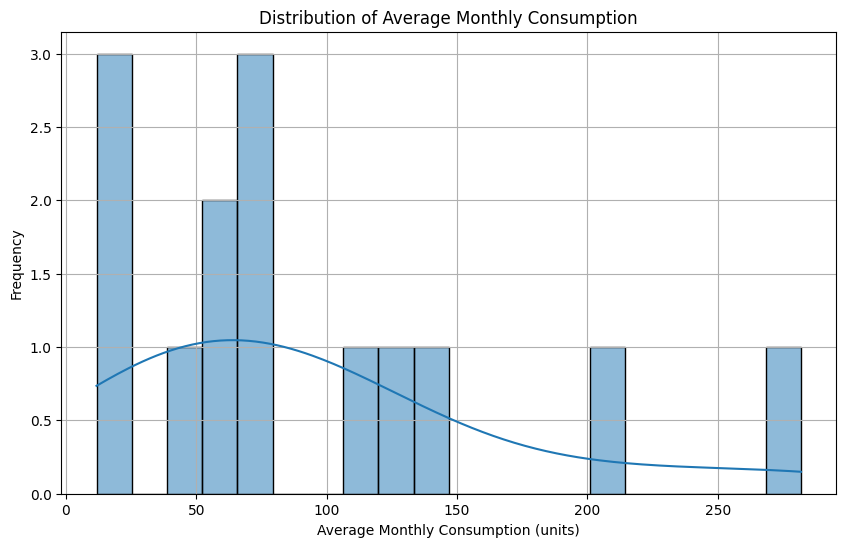

In [33]:
# Consumption Distribution Analysis
plt.figure(figsize=(10, 6))
sns.histplot(df['avg_consumption'], bins=20, kde=True)
plt.title('Distribution of Average Monthly Consumption')
plt.xlabel('Average Monthly Consumption (units)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

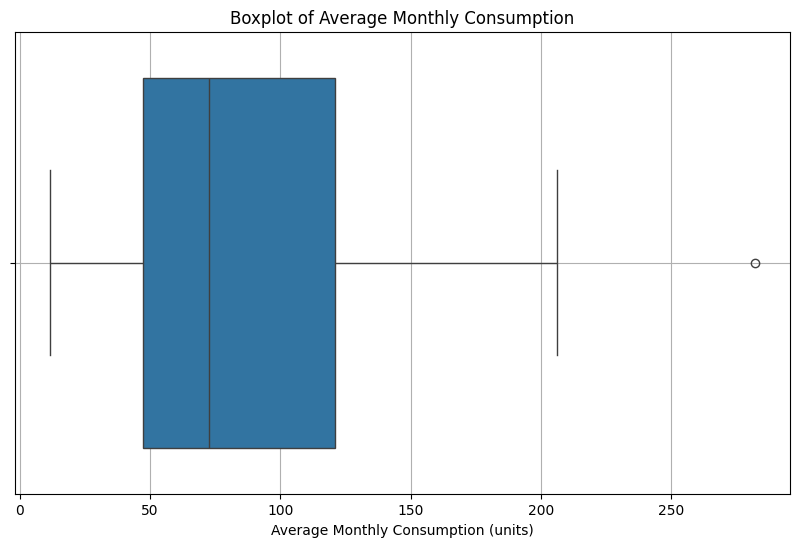

In [34]:
# Boxplot for outlier detection (Investigating Outliers)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='avg_consumption')
plt.title('Boxplot of Average Monthly Consumption')
plt.xlabel('Average Monthly Consumption (units)')
plt.grid(True)
plt.show()


In [35]:
# Summary of key metrics
total_homes = df.shape[0]
avg_consumption = df['avg_consumption'].mean()
median_consumption = df['avg_consumption'].median()
max_consumption = df['avg_consumption'].max()
min_consumption = df['avg_consumption'].min()

print("\nSummary of Key Metrics:")
print(f"Total number of homes: {total_homes}")
print(f"Average consumption: {avg_consumption:.2f} units")
print(f"Median consumption: {median_consumption:.2f} units")
print(f"Maximum consumption: {max_consumption:.2f} units")
print(f"Minimum consumption: {min_consumption:.2f} units")


Summary of Key Metrics:
Total number of homes: 14
Average consumption: 92.44 units
Median consumption: 72.86 units
Maximum consumption: 282.00 units
Minimum consumption: 11.71 units
